# **Histopathological Image Segmentation using an Improved BASNet (U-Net based) Model**

This notebook demonstrates how to segment nuclei in histopathological images (e.g., the [MoNuSeg dataset](https://monuseg.grand-challenge.org/)) using a U-Net-like architecture, **BASNet**, enriched with:

1. **Attention blocks** (self-attention),
2. **Dense blocks** in the decoder,
3. A **custom segmentation loss** combining *Dice loss*, *Focal loss*, and *SSIM loss*,
4. Additional metrics:
   - **Dice Similarity Coefficient** (DSC),
   - **Intersection over Union (IoU)**,
   - **Pixel Accuracy**,
   - **Boundary F1-Score** (a boundary-based metric).

We also track and plot the training/validation loss curves to see how the model progresses during training.


---
## **1. Imports & Setup**

We first import our dependencies and define some constants:

- **`IMAGE_SIZE`**: Desired image resolution (the model input size).
- **`BATCH_SIZE`**: The batch size for training.
- **`OUT_CLASSES`**: Number of output classes (in this case, **1** for binary segmentation).
- **`TRAIN_SPLIT_RATIO`**: The proportion of the dataset used for training (the remainder is for validation).
- **`EPOCHS`**: Number of training epochs.
- **`INITIAL_LEARNING_RATE`**: Initial learning rate for the optimizer.
- **`IMAGES_DIR`** & **`ANNOTATIONS_DIR`**: Directories to the dataset images and corresponding XML annotations.


In [66]:
%pip install opencv-python


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [67]:
import tensorflow as tf
tf.keras.backend.clear_session()

# from tensorflow.python.client import device[]_lib
# print(device_lib.list_local_devices())

import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tensorflow import keras
from keras import layers, Model
from tensorflow.keras.applications import ResNet50V2
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
import cv2   # For boundary morphological operations in custom callbacks

print("TensorFlow version:", tf.__version__)

# Constants
IMAGE_SIZE = 256
BATCH_SIZE = 8
OUT_CLASSES = 1
TRAIN_SPLIT_RATIO = 0.85
EPOCHS = 50
INITIAL_LEARNING_RATE = 3e-4

# Paths to your dataset
IMAGES_DIR = './Dataset/Images'
ANNOTATIONS_DIR = './Dataset/Annotations'

TensorFlow version: 2.14.0


---
## **2. Attention and Dense Block Layers**

We define custom Keras layers:

1. **`AttentionBlock`**: Implements a simple self-attention mechanism with Query-Key-Value.  
2. **`DenseBlock`**: A small repeating block that concatenates previous features and then applies a convolution (similar to DenseNet).

In [68]:
class AttentionBlock(layers.Layer):
    def __init__(self, filters):
        super(AttentionBlock, self).__init__()
        self.filters = filters
        self.conv_query = layers.Conv2D(filters, 1, padding='same')
        self.conv_key   = layers.Conv2D(filters, 1, padding='same')
        self.conv_value = layers.Conv2D(filters, 1, padding='same')
        self.conv_out   = layers.Conv2D(filters, 1, padding='same')

    def call(self, x):
        query = self.conv_query(x)
        key = self.conv_key(x)
        value = self.conv_value(x)

        batch_size = tf.shape(x)[0]
        h = tf.shape(x)[1]
        w = tf.shape(x)[2]

        query = tf.reshape(query, [batch_size, -1, self.filters])
        key = tf.reshape(key, [batch_size, -1, self.filters])
        value = tf.reshape(value, [batch_size, -1, self.filters])

        scores = tf.matmul(query, key, transpose_b=True)
        attention_weights = tf.nn.softmax(scores)

        context = tf.matmul(attention_weights, value)
        context = tf.reshape(context, [batch_size, h, w, self.filters])
        out = self.conv_out(context)
        return x + out


class DenseBlock(layers.Layer):
    def __init__(self, filters, num_layers):
        super(DenseBlock, self).__init__()
        self.blocks = []
        for _ in range(num_layers):
            self.blocks.append(layers.Conv2D(filters, 3, padding='same', activation='relu'))

    def call(self, x):
        features = [x]
        for block in self.blocks:
            concat_features = tf.concat(features, axis=-1)
            new_features = block(concat_features)
            features.append(new_features)
        return tf.concat(features, axis=-1)

---
## **3. Data Preprocessing**

### **3.1. XML Parsing & Mask Creation**
We have a function `create_mask_from_xml` that uses the *PIL* library to draw polygon regions from the XML annotations.

### **3.2. Loading Image & Annotation Paths**

Function `load_paths` pairs image files and XML annotation files, then splits them into training and validation sets based on a ratio.

### **3.3. Preprocessing Function**

Function `preprocess` resizes images and constructs the masks accordingly (resized to the same shape).

### **3.4. Create TF Dataset**

Function `load_dataset` builds a `tf.data.Dataset` pipeline. We shuffle, batch, and prefetch to optimize performance.

In [69]:
def create_mask_from_xml(xml_path, image_size):
    """
    Parses an XML annotation file and creates a binary mask.
    """
    mask = Image.new('L', image_size, 0)
    draw = ImageDraw.Draw(mask)

    tree = ET.parse(xml_path)
    root = tree.getroot()

    for region in root.findall('.//Region'):
        vertices = []
        for vertex in region.findall('.//Vertex'):
            x = float(vertex.get('X'))
            y = float(vertex.get('Y'))
            vertices.append((x, y))

        if vertices:
            draw.polygon(vertices, outline=1, fill=1)

    mask_array = np.array(mask, dtype=np.float32)
    return mask_array

def load_paths(images_dir, annotations_dir, split_ratio):
    image_paths = sorted(glob(os.path.join(images_dir, '*.tif')))
    annotation_paths = sorted(glob(os.path.join(annotations_dir, '*.xml')))

    print("Number of image files:", len(image_paths))
    print("Number of annotation files:", len(annotation_paths))

    assert len(image_paths) == len(annotation_paths), "Mismatch between images and annotations."

    len_ = int(len(image_paths) * split_ratio)
    return (image_paths[:len_], annotation_paths[:len_]), (image_paths[len_:], annotation_paths[len_:])

def preprocess(image_path, annotation_path, img_size, out_classes):
    def f(_image_path, _annotation_path):
        # Decode bytes if necessary
        if isinstance(_image_path, bytes):
            _image_path = _image_path.decode('utf-8')
        elif isinstance(_image_path, np.ndarray):
            _image_path = _image_path.item()
            if isinstance(_image_path, bytes):
                _image_path = _image_path.decode('utf-8')

        if isinstance(_annotation_path, bytes):
            _annotation_path = _annotation_path.decode('utf-8')
        elif isinstance(_annotation_path, np.ndarray):
            _annotation_path = _annotation_path.item()
            if isinstance(_annotation_path, bytes):
                _annotation_path = _annotation_path.decode('utf-8')

        # Load and preprocess image
        image = Image.open(_image_path).convert('RGB')
        original_size = image.size
        image = image.resize((img_size, img_size))
        image_array = np.array(image, dtype=np.float32) / 255.0

        # Create and resize mask
        mask = create_mask_from_xml(_annotation_path, original_size)
        mask = Image.fromarray(mask).resize((img_size, img_size))
        mask_array = np.array(mask, dtype=np.float32)
        mask_array = np.expand_dims(mask_array, axis=-1)

        return image_array, mask_array

    image, mask = tf.numpy_function(f, [image_path, annotation_path], [tf.float32, tf.float32])
    image.set_shape([img_size, img_size, 3])
    mask.set_shape([img_size, img_size, out_classes])
    return image, mask

def load_dataset(image_paths, annotation_paths, img_size, out_classes, batch_size, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, annotation_paths))
    if shuffle:
        dataset = dataset.cache().shuffle(buffer_size=1000)
    dataset = dataset.map(
        lambda x, y: preprocess(x, y, img_size, out_classes),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

---
## **4. Custom BASNet Model**

We leverage **ResNet50V2** as an encoder and then create a U-Net-like decoder with:
1. **Attention** blocks in the deeper layers.
2. **Dense blocks** in the upsampling path to combine features.

**Output**: A single-channel segmentation mask (activated with `sigmoid`).


In [70]:
def improved_basnet(input_shape, out_classes):
    inputs = layers.Input(input_shape)

    # Use ResNet50V2 as backbone
    backbone = ResNet50V2(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs
    )

    # Extract features at different levels
    c1 = backbone.get_layer('conv1_conv').output
    c2 = backbone.get_layer('conv2_block3_out').output
    c3 = backbone.get_layer('conv3_block4_out').output
    c4 = backbone.get_layer('conv4_block6_out').output
    c5 = backbone.get_layer('conv5_block3_out').output

    print("Encoder feature shapes:", c1.shape, c2.shape, c3.shape, c4.shape, c5.shape)

    # Add attention blocks
    c3 = AttentionBlock(512)(c3)
    c4 = AttentionBlock(1024)(c4)
    c5 = AttentionBlock(2048)(c5)

    # Decoder path with dense blocks
    p5 = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(c5)
    c4_up = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(c4)
    p5 = layers.concatenate([p5, c4_up])
    p5 = DenseBlock(256, 3)(p5)

    p4 = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(p5)
    c3_up = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(c3)
    p4 = layers.concatenate([p4, c3_up])
    p4 = DenseBlock(128, 3)(p4)

    p3 = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(p4)
    c2_up = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(c2)
    p3 = layers.concatenate([p3, c2_up])
    p3 = DenseBlock(64, 3)(p3)

    p2 = layers.Conv2DTranspose(32, 4, strides=2, padding='same')(p3)
    p2 = layers.concatenate([p2, c1])
    p2 = DenseBlock(32, 3)(p2)

    p1 = layers.Conv2DTranspose(16, 4, strides=2, padding='same')(p2)
    p1 = DenseBlock(16, 3)(p1)

    outputs = layers.Conv2D(out_classes, 1, padding='same', activation='sigmoid')(p1)

    return Model(inputs=[inputs], outputs=[outputs])

---
## **5. Custom Loss**

### **5.1. Dice Loss**
\[
    \text{DiceLoss} = 1 - \frac{2 \times (y_\text{true} \cdot y_\text{pred})}{y_\text{true} + y_\text{pred} + \epsilon}
\]

### **5.2. Focal Loss** (with parameters \(\gamma\) and \(\alpha\))
\[
    \text{FocalLoss} = -\alpha \, y_\text{true}(1 - y_\text{pred})^\gamma \log(y_\text{pred})
    \;-\; (1-\alpha) (1 - y_\text{true}) \,y_\text{pred}^\gamma \log(1-y_\text{pred})
\]

### **5.3. SSIM Loss**
\[
    \text{SSIM\_Loss} = 1 - \text{mean}(\text{SSIM}(y_\text{true}, y_\text{pred}))
\]

### **5.4. Combined**
A weighted combination:
\[
    0.4 \times \text{DiceLoss} + 0.4 \times \text{FocalLoss} + 0.2 \times \text{SSIM\_Loss}
\]

In [71]:
class CustomSegmentationLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super(CustomSegmentationLoss, self).__init__(name="custom_seg_loss", **kwargs)
        self.smooth = 1e-9

    def dice_loss(self, y_true, y_pred):
        y_true_f = tf.reshape(y_true, [-1])
        y_pred_f = tf.reshape(y_pred, [-1])
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        return 1 - (2. * intersection + self.smooth) / (
            tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + self.smooth)

    def focal_loss(self, y_true, y_pred, gamma=2.0, alpha=0.25):
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
        loss = - y_true * alpha * tf.pow(1 - y_pred, gamma) * tf.math.log(y_pred) \
               - (1 - y_true) * (1 - alpha) * tf.pow(y_pred, gamma) * tf.math.log(1 - y_pred)
        return tf.reduce_mean(loss)

    def call(self, y_true, y_pred):
        dice = self.dice_loss(y_true, y_pred)
        focal = self.focal_loss(y_true, y_pred)
        ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
        return (0.4 * dice) + (0.4 * focal) + (0.2 * ssim_loss)

---
## **6. Additional Metrics**

Below, we define custom Keras metrics:
- **Dice Coefficient** (threshold at 0.5),
- **IoU** (threshold at 0.5),
- **Pixel Accuracy** (threshold at 0.5).

These will accumulate values during each batch and output the average metric result at the end of each epoch.

In [72]:
class DiceMetric(tf.keras.metrics.Metric):
    """
    Computes the average Dice Coefficient for a batch.
    By default, uses a 0.5 threshold on y_pred for binarization.
    """
    def __init__(self, name='dice_metric', **kwargs):
        super(DiceMetric, self).__init__(name=name, **kwargs)
        self.dice_sum = self.add_weight(name='dice_sum', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        intersection = tf.reduce_sum(y_true * y_pred)
        union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
        dice = (2.0 * intersection + 1e-7) / (union + 1e-7)
        self.dice_sum.assign_add(dice)
        self.count.assign_add(1.0)

    def result(self):
        return self.dice_sum / self.count

    def reset_state(self):
        self.dice_sum.assign(0.0)
        self.count.assign(0.0)


class IoUMetric(tf.keras.metrics.Metric):
    """
    Computes the average Intersection over Union (IoU) for a batch,
    thresholded at 0.5.
    """
    def __init__(self, name='iou_metric', **kwargs):
        super(IoUMetric, self).__init__(name=name, **kwargs)
        self.iou_sum = self.add_weight(name='iou_sum', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        intersection = tf.reduce_sum(y_true * y_pred)
        union = tf.reduce_sum(tf.cast(y_true + y_pred >= 1, tf.float32))
        iou = (intersection + 1e-7) / (union + 1e-7)
        self.iou_sum.assign_add(iou)
        self.count.assign_add(1.0)

    def result(self):
        return self.iou_sum / self.count

    def reset_state(self):
        self.iou_sum.assign(0.0)
        self.count.assign(0.0)


class PixelAccuracy(tf.keras.metrics.Metric):
    """
    Computes pixel accuracy for binary segmentation with 0.5 threshold.
    """
    def __init__(self, name='pixel_accuracy', **kwargs):
        super(PixelAccuracy, self).__init__(name=name, **kwargs)
        self.total_pixels = self.add_weight(name='total_pixels', initializer='zeros')
        self.correct_pixels = self.add_weight(name='correct_pixels', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        correct = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
        total = tf.cast(tf.size(y_true), tf.float32)
        self.correct_pixels.assign_add(correct)
        self.total_pixels.assign_add(total)

    def result(self):
        return self.correct_pixels / (self.total_pixels + 1e-7)

    def reset_state(self):
        self.correct_pixels.assign(0.0)
        self.total_pixels.assign(0.0)

---
## **7. Boundary F1-Score Callback**

The **Boundary F1** metric compares the boundaries of the predicted mask with the boundaries of the ground truth mask. We:
1. Extract boundaries by subtracting an eroded version from the original mask.
2. Dilate boundaries to allow small localization errors.
3. Compute **Precision** and **Recall** for boundary pixels.
4. Derive the **F1** score.

**Note**: This can be computationally expensive. We compute it on the entire validation dataset by default, but you might sample or reduce frequency if the dataset is large.

In [73]:
class BoundaryF1Callback(keras.callbacks.Callback):
    """
    Computes a boundary-based F1 score at the end of each epoch on the entire val_dataset.
    """
    def __init__(self, val_dataset, batch_size=8, name='boundary_f1', dilation_ratio=0.01):
        super().__init__()
        self.val_dataset = val_dataset
        self.name = name
        self.dilation_ratio = dilation_ratio
        self.batch_size = batch_size

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        boundary_f1_scores = []
        for images, masks in self.val_dataset:
            preds = self.model.predict(images, verbose=0)
            preds = (preds > 0.5).astype(np.uint8)
            masks = masks.numpy().astype(np.uint8)

            for i in range(images.shape[0]):
                bf1 = self._boundary_f1(masks[i, ..., 0], preds[i, ..., 0])
                boundary_f1_scores.append(bf1)

        mean_bf1 = np.mean(boundary_f1_scores)
        logs[self.name] = mean_bf1
        print(f" — val_{self.name}: {mean_bf1:.4f}")

    def _boundary_f1(self, mask_true, mask_pred):
        # Extract boundary for y_true
        boundary_true = self._extract_boundary(mask_true)
        # Extract boundary for y_pred
        boundary_pred = self._extract_boundary(mask_pred)

        # Dilate boundaries
        radius = max(1, int(round(self.dilation_ratio * max(mask_true.shape))))
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (radius, radius))
        boundary_true_dil = cv2.dilate(boundary_true, kernel)
        boundary_pred_dil = cv2.dilate(boundary_pred, kernel)

        # Intersection of predicted boundary with GT boundary's dilation
        matches_pred = np.sum(boundary_pred * boundary_true_dil > 0)
        # Intersection of GT boundary with predicted boundary's dilation
        matches_true = np.sum(boundary_true * boundary_pred_dil > 0)

        # Number of boundary pixels
        boundary_true_pixels = np.sum(boundary_true)
        boundary_pred_pixels = np.sum(boundary_pred)

        # Precision / Recall
        precision = matches_pred / (boundary_pred_pixels + 1e-7)
        recall = matches_true / (boundary_true_pixels + 1e-7)
        if precision + recall == 0:
            return 0.0

        f1 = 2 * precision * recall / (precision + recall)
        return f1

    def _extract_boundary(self, mask):
        mask = (mask > 0).astype(np.uint8)
        kernel = np.ones((3,3), np.uint8)
        eroded = cv2.erode(mask, kernel, iterations=1)
        boundary = mask - eroded
        return boundary

---
## **8. Utility Callbacks & Visualization**

Here we define:
- A set of **common callbacks** for training (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint).
- A **display** function to visualize original, ground truth, and predicted masks side-by-side.

In [74]:
def get_callbacks(val_dataset):
    return [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        ),
        keras.callbacks.ModelCheckpoint(
            'best_model.weights.h5',
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True
        ),
        # Our boundary F1 callback
        BoundaryF1Callback(val_dataset=val_dataset, name="boundary_f1")
    ]

def display(display_list):
    """
    display_list: [input_image, true_mask, predicted_mask]
    """
    title = ["Input Image", "True Mask", "Predicted Mask"]
    plt.figure(figsize=(15, 5))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
        plt.axis("off")
    plt.show()

In [75]:
import cv2
import numpy as np

def color_instances(binary_mask):
    """
    Takes a 2D binary mask with shape (H, W), where
      1 = foreground/nucleus
      0 = background
    Returns an RGB image (H, W, 3) that assigns a unique color
    to each connected component in the binary mask.
    """
    binary_mask = (binary_mask > 0).astype(np.uint8)
    num_labels, labels = cv2.connectedComponents(binary_mask, connectivity=8)

    # Create an empty RGB image
    h, w = binary_mask.shape
    colored_mask = np.zeros((h, w, 3), dtype=np.uint8)

    # Use a random generator for colors
    rng = np.random.default_rng(seed=42)  # or remove `seed=42` for fully random
    for label_id in range(1, num_labels):
        color = rng.integers(0, 256, size=3, dtype=np.uint8)
        colored_mask[labels == label_id] = color

    return colored_mask

---
## **9. Prepare Datasets**

Using the earlier helper functions, we load the training and validation datasets.

In [76]:
train_paths, val_paths = load_paths(IMAGES_DIR, ANNOTATIONS_DIR, TRAIN_SPLIT_RATIO)

train_dataset = load_dataset(
    train_paths[0], train_paths[1], IMAGE_SIZE, OUT_CLASSES, BATCH_SIZE, shuffle=True
)
val_dataset = load_dataset(
    val_paths[0], val_paths[1], IMAGE_SIZE, OUT_CLASSES, BATCH_SIZE, shuffle=False
)

print("\nTraining set batches:", len(train_dataset))
print("Validation set batches:", len(val_dataset))

Number of image files: 37
Number of annotation files: 37

Training set batches: 4
Validation set batches: 1


---
## **10. Compile & Train the Model**

We **compile** with:
- **Optimizer**: Adam
- **Loss**: Our `CustomSegmentationLoss`
- **Metrics**: Custom `DiceMetric`, `IoUMetric`, `PixelAccuracy` (and optionally others).

We then **fit** the model with the callback set including boundary F1, early stopping, etc.

In [77]:
model = improved_basnet(input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3], out_classes=OUT_CLASSES)
optimizer = keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss=CustomSegmentationLoss(),
    metrics=[
        DiceMetric(),
        IoUMetric(),
        PixelAccuracy(),
        # Optionally: keras.metrics.BinaryAccuracy(), ...
    ]
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=get_callbacks(val_dataset)
)

# saving the model
model.save("basnet_custom_loss_model_z.h5")

Encoder feature shapes: (None, 128, 128, 64) (None, 32, 32, 256) (None, 16, 16, 512) (None, 8, 8, 1024) (None, 8, 8, 2048)
Epoch 1/50
4/4 [==============================] - 60s 6s/step - loss: 0.5802 - dice_metric: 0.2436 - iou_metric: 0.1995 - pixel_accuracy: 0.3165 - val_loss: 0.5120 - val_dice_metric: 0.1080 - val_iou_metric: 0.1062 - val_pixel_accuracy: 0.2005 - lr: 3.0000e-04 - boundary_f1: 0.3682
Epoch 2/50
4/4 [==============================] - 35s 9s/step - loss: 0.4970 - dice_metric: 0.3036 - iou_metric: 0.2664 - pixel_accuracy: 0.3824 - val_loss: 0.4198 - val_dice_metric: 0.5422 - val_iou_metric: 0.5159 - val_pixel_accuracy: 0.1803 - lr: 3.0000e-04 - boundary_f1: 0.7606
Epoch 3/50
4/4 [==============================] - 37s 6s/step - loss: 0.4523 - dice_metric: 0.4388 - iou_metric: 0.4094 - pixel_accuracy: 0.4139 - val_loss: 0.3755 - val_dice_metric: 0.6353 - val_iou_metric: 0.6192 - val_pixel_accuracy: 0.1923 - lr: 3.0000e-04 - boundary_f1: 0.8158
Epoch 4/50
4/4 [============

---
## **11. Plotting the Loss and Metric Curves**

We can visualize how our training evolves using the `history.history` dictionary.

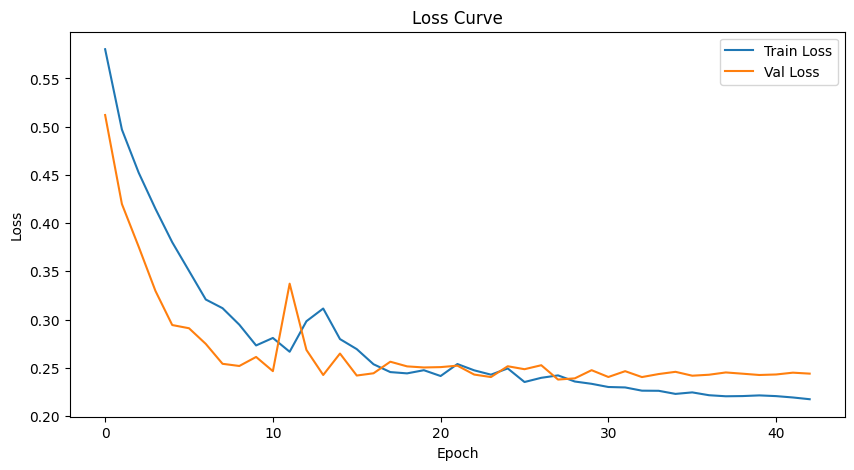

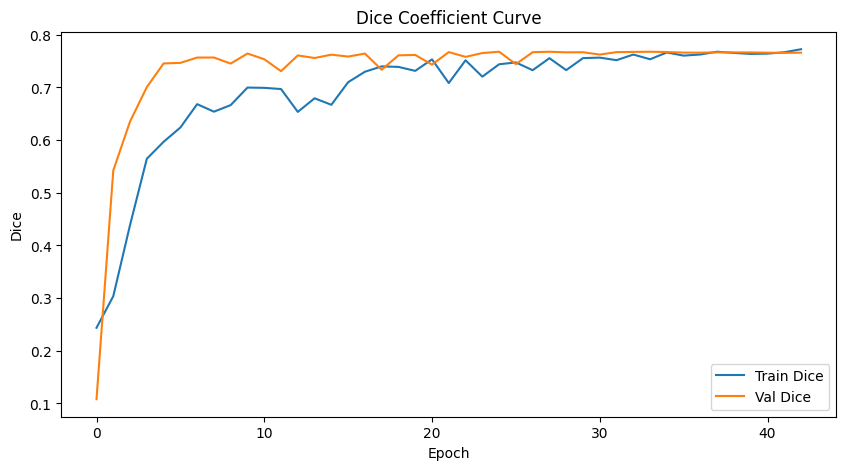

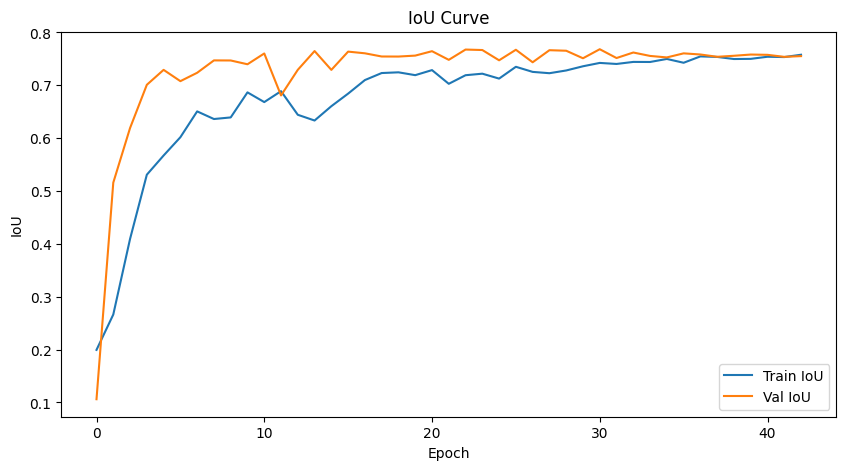

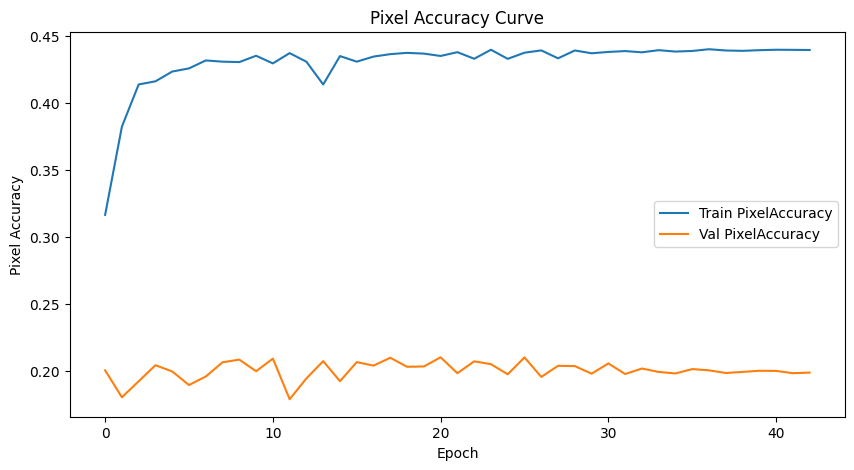

In [78]:
# Plot the training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Dice Metric if it exists in history
plt.figure(figsize=(10, 5))
if 'dice_metric' in history.history:
    plt.plot(history.history['dice_metric'], label='Train Dice')
if 'val_dice_metric' in history.history:
    plt.plot(history.history['val_dice_metric'], label='Val Dice')
plt.title('Dice Coefficient Curve')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.show()

# Plot IoU Metric
plt.figure(figsize=(10, 5))
if 'iou_metric' in history.history:
    plt.plot(history.history['iou_metric'], label='Train IoU')
if 'val_iou_metric' in history.history:
    plt.plot(history.history['val_iou_metric'], label='Val IoU')
plt.title('IoU Curve')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.show()

# Similarly for pixel accuracy
plt.figure(figsize=(10, 5))
if 'pixel_accuracy' in history.history:
    plt.plot(history.history['pixel_accuracy'], label='Train PixelAccuracy')
if 'val_pixel_accuracy' in history.history:
    plt.plot(history.history['val_pixel_accuracy'], label='Val PixelAccuracy')
plt.title('Pixel Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.legend()
plt.show()

---
## **12. Testing / Inference**

Finally, let's define a helper function to visualize the model predictions on a *single* validation sample:

1/1 [==============================] - 0s 23ms/step


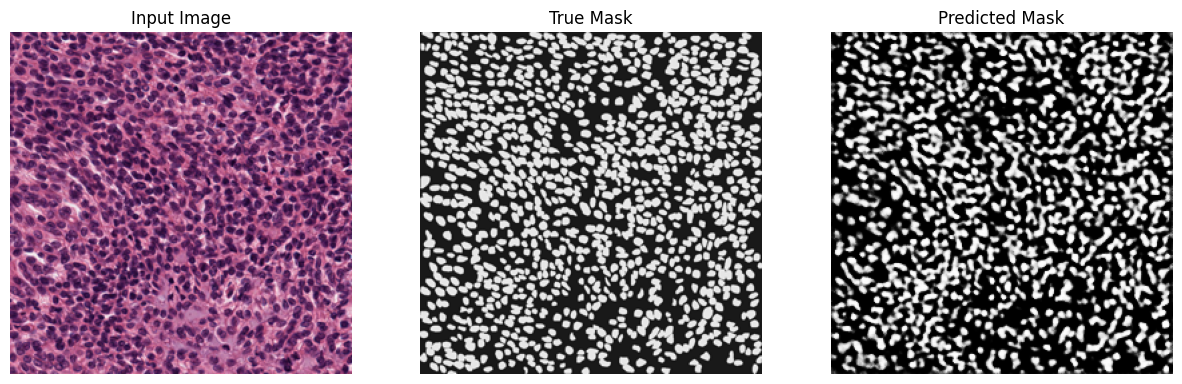

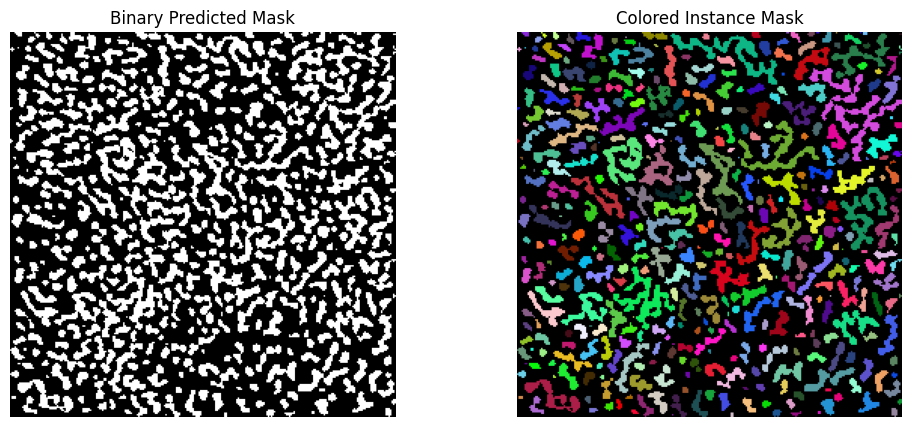

In [79]:
# ------------------------------------------
#       IF MODEL IS ALREADY TRAINED        |
#-------------------------------------------

# model = keras.models.load_model(
#     "my_basnet_model.h5",
#     custom_objects={
#         "AttentionBlock": AttentionBlock,
#         "DenseBlock": DenseBlock,
#         "CustomSegmentationLoss": CustomSegmentationLoss,
#         "DiceMetric": DiceMetric,
#         "IoUMetric": IoUMetric,
#         "PixelAccuracy": PixelAccuracy
#     }
# )

def normalize_output(prediction):
    """
    Normalize predicted mask for visualization (0-1 range).
    """
    max_value = np.max(prediction)
    min_value = np.min(prediction)
    if max_value - min_value == 0:
        return prediction
    return (prediction - min_value) / (max_value - min_value)

def test_specific_image(index):
    test_image_path = val_paths[0][index]
    test_annotation_path = val_paths[1][index]

    test_image_path_tensor = tf.constant(test_image_path)
    test_annotation_path_tensor = tf.constant(test_annotation_path)

    test_image, test_mask = preprocess(
        test_image_path_tensor,
        test_annotation_path_tensor,
        IMAGE_SIZE,
        OUT_CLASSES
    )

    test_image = tf.expand_dims(test_image, axis=0)
    test_mask = tf.expand_dims(test_mask, axis=0)

    # Step 1: Predict
    pred_mask = model.predict(test_image)

    # Step 2: Display the usual results (input image, true mask, predicted mask)
    # (unchanged code)
    display([test_image[0], test_mask[0], normalize_output(pred_mask[0])])

    # == ADD THIS BLOCK BELOW to show colored output ==
    # Convert pred_mask[0] to a binary mask
    binary_pred = (pred_mask[0, ..., 0] > 0.5).astype(np.uint8)
    colored = color_instances(binary_pred)

    # Visualize the colored output
    plt.figure(figsize=(12, 5))

    # Original predicted mask (binary)
    plt.subplot(1, 2, 1)
    plt.title("Binary Predicted Mask")
    plt.imshow(binary_pred, cmap='gray')
    plt.axis("off")

    # Uniquely colored mask
    plt.subplot(1, 2, 2)
    plt.title("Colored Instance Mask")
    plt.imshow(colored)
    plt.axis("off")

    plt.show()

# For example, test the 3rd item in validation set
test_specific_image(3)

---
# **End of Notebook**

We have successfully:
1. Built an Improved BASNet (U-Net-like) model for histopathological image segmentation.
2. Used a composite loss function (Dice + Focal + SSIM).
3. Tracked additional metrics (Dice, IoU, Pixel Accuracy, and a boundary F1-score).
4. Visualized training/validation losses and metrics.

**Next steps** might include:
- Hyperparameter tuning (e.g. adjusting learning rate, batch size).
- Data augmentations (random flips, rotations, etc.) to improve generalization.
- Trying different encoders (e.g., EfficientNet, other architectures).
- Computing boundary-based metrics less frequently or on a smaller subset if runtime is an issue.
